<a href="https://colab.research.google.com/github/davidfague/Neural-Modeling/blob/main/NMDAExploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
is_colab = 'google.colab' in str(get_ipython())

In [2]:
if is_colab:
    !git clone https://github.com/davidfague/Neural-Modeling.git
    from google.colab import drive
    drive.mount('/content/drive')
    %cd /content/drive/MyDrive/

Cloning into 'Neural-Modeling'...
remote: Enumerating objects: 910, done.
remote: Counting objects: 100% (467/467), done.
remote: Compressing objects: 100% (202/202), done.
remote: Total 910 (delta 308), reused 396 (delta 264), pack-reused 443
Receiving objects: 100% (910/910), 5.67 MiB | 21.19 MiB/s, done.
Resolving deltas: 100% (579/579), done.
Mounted at /content/drive
/content/drive/MyDrive


In [3]:
import pandas as pd
import h5py
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.signal as ss
from mpl_toolkits import mplot3d
import pdb #python debugger

Specify output folder and read data

In [4]:
output_folder = 'L5PCtemplate[0]_45e-1Hz_196nseg_2000ms_108nbranch_29068NCs_29068nsyn'

# output_folder = 'L5PCtemplate[0]_15e-1Hz_642nseg_2000ms_108nbranch_29068NCs_29068nsyn'

v = h5py.File('./{}/Vm_report.h5'.format(output_folder),'r') #read segment voltage traces

gNaTa = h5py.File('./{}/gNaTa_T_data_report.h5'.format(output_folder),'r') #read segment voltage traces
iampa = h5py.File('./{}/i_AMPA_report.h5'.format(output_folder),'r') #read segment voltage traces
inmda = h5py.File('./{}/i_NMDA_report.h5'.format(output_folder),'r') #read segment voltage traces
igaba = h5py.File('./{}/i_GABA_report.h5'.format(output_folder),'r') #read segment voltage traces
icah = h5py.File('./{}/icah_data_report.h5'.format(output_folder),'r') #read segment voltage traces
ical = h5py.File('./{}/ical_data_report.h5'.format(output_folder),'r') #read segment voltage traces
ih = h5py.File('./{}/ih_data_report.h5'.format(output_folder),'r') #read segment voltage traces
ina = h5py.File('./{}/ina_data_report.h5'.format(output_folder),'r') #read segment voltage traces

spikes = h5py.File('./{}/spikes_report.h5'.format(output_folder),'r') #read segment voltage traces

segs = pd.read_csv('./{}/seg_info.csv'.format(output_folder)) # read segment values

In [5]:
v=v['report']['biophysical']['data']
gNaTa=gNaTa['report']['biophysical']['data']
iampa=iampa['report']['biophysical']['data']
inmda=inmda['report']['biophysical']['data']
igaba=igaba['report']['biophysical']['data']
icah=icah['report']['biophysical']['data']
ical=ical['report']['biophysical']['data']
ih=ih['report']['biophysical']['data']
ina=ina['report']['biophysical']['data']
spikes=spikes['report']['biophysical']['data']

Voltage and current criterion

In [6]:
def voltage_criterion(data=None, v_thresh=-40, time_thresh=260):
    threshold_crossings = np.diff(data > v_thresh, prepend=False)
    upward_crossings = np.argwhere(threshold_crossings)[::2,0]
    downward_crossings = np.argwhere(threshold_crossings)[1::2,0]
    # If length of threshold_crossings is not even
    if np.mod(np.argwhere(threshold_crossings).reshape(-1,).shape[0],2)!=0:
        legit_up_crossings = upward_crossings[:-1][np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>time_thresh]
        legit_down_crossings = downward_crossings[np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>time_thresh]
    else:
        legit_up_crossings = upward_crossings[np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>time_thresh]
        legit_down_crossings = downward_crossings[np.diff(np.argwhere(threshold_crossings).reshape(-1,))[::2]>time_thresh]
    return upward_crossings, legit_up_crossings, legit_down_crossings

# Input: upward and downward crossings
# Output: bounds of NMDA spikes meeting current criterion
def current_criterion(legit_uc_iso=[], legit_dc_iso=[], p=1, control_inmda=np.array([1])):
    bounds = []
    sum_current = []


    for ind1 in np.arange(0,len(legit_uc_iso)):
        e1 = control_inmda[legit_uc_iso[ind1], p] #current @ up_crossing[ind1]
        #all the indices where current crosses 130% of e1
        x30 = np.argwhere(np.diff(control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p] < 1.3*e1, prepend=False))
        #all the indices where current crosses 115% of e1
        x15 = np.argwhere(np.diff(control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p] < 1.15*e1, prepend=False))

        if len(x30)>0:

            x15_copy = x15
            x30_copy = x30

            try:
                i = x30[0][0]
            except:
                import pdb; pdb.set_trace()

            n = 0


            while n==0:
                if len(np.sort(x15[x15>i]))!=0:
                    b1 = i
                    b2 = np.sort(x15[x15>i])[0]
                    bounds.append([legit_uc_iso[ind1]+b1,legit_uc_iso[ind1]+b2])
                    sum_current.append(np.sum(control_inmda[legit_uc_iso[ind1]+b1:legit_uc_iso[ind1]+b2,p])/10)
                else:
                    b1 = i
                    b2 = (legit_dc_iso[ind1]-legit_uc_iso[ind1])
                    bounds.append([legit_uc_iso[ind1]+b1,legit_uc_iso[ind1]+b2])
                    sum_current.append(np.sum(control_inmda[legit_uc_iso[ind1]+b1:legit_uc_iso[ind1]+b2,p])/10)
                    n=1

                x30_copy = x30_copy[x30_copy>legit_uc_iso[ind1]+b2]
                #import pdb; pdb.set_trace()

                if len(x30_copy)!=0:
                    i = x30_copy[x30_copy>b2][0]
                else:
                    n=1
    return bounds, sum_current


Separate segment elec distance and distance into quantiles

In [7]:
import ast

def try_literal_eval(s):
    try:
        return ast.literal_eval(s)
    except ValueError:
        return s

segs['seg elec distance'] = segs['seg elec distance'].apply(try_literal_eval)

In [8]:
# Define a function to retrieve a value from the nested dictionary
def get_value_from_nested_dict(row, key1, key2):
    return row['seg elec distance'].get(key1, {}).get(key2, None)  # return None if any key not found

# Apply the function to each row of the DataFrame to create a new column
segs['Elec_distance'] = segs.apply(get_value_from_nested_dict, args=('beta', 'passive_soma',), axis=1)

In [9]:
try:
  segs_degrees = pd.read_csv(degrees_f).groupby(['Sec ID','Type'])['Degrees'].max().reset_index() #degrees_f is segment degrees .csv file
except:
  print('Segment Degrees Missing')

segs['segmentID'] = segs.index

try:
  segs = segs.set_index(['Type','Sec ID']).join(segs_degrees.set_index(['Type','Sec ID'])).reset_index()
except:
  print('Segment Degrees Missing')

segs['sec index'] = segs['sec index'].astype(int)
segs['x'] = segs['x'].astype(float)
segs['Distance'] = segs['seg h.distance']
segs['Elec DistanceQ'] = None
segs['DistanceQ'] = None

#get simulation time
v_len=len(v[:,0])
tstop=2000.1 #simulation stop
dt=0.1 #timestep
t=np.arange(0,tstop,dt) #time array
print(v_len) #should be equivalnt to (tstop=1000ms)/(dt=0.1ms)=10000
print(len(t))
if len(t)!=v_len:
  raise ValueError('Update Time array')

segs.loc[segs.Type=='dend','Elec DistanceQ'] = pd.qcut(segs.loc[segs.Type=='dend','Elec_distance'], 10, labels=False, duplicates = 'drop')
segs.loc[segs.Type=='apic','Elec DistanceQ'] = pd.qcut(segs.loc[segs.Type=='apic','Elec_distance'], 10, labels=False, duplicates = 'drop')
segs.loc[segs.Type=='dend','DistanceQ'] = pd.qcut(segs.loc[segs.Type=='dend','seg h.distance'], 10, labels=False, duplicates = 'drop')
segs.loc[segs.Type=='apic','DistanceQ'] = pd.qcut(segs.loc[segs.Type=='apic','seg h.distance'], 10, labels=False, duplicates = 'drop')

save_dfs = False

Segment Degrees Missing
Segment Degrees Missing
20001
20001


In [10]:
!git clone https://github.com/davidfague/Neural-Modeling.git

fatal: destination path 'Neural-Modeling' already exists and is not an empty directory.


In [11]:
%cd Neural-Modeling/

/content/drive/MyDrive/Neural-Modeling


In [12]:
from Modules.segment import Segment

In [13]:
%cd ..

/content/drive/MyDrive


In [14]:
segments=[]

# Use Segment() class to store segment info and recorded data
for i in range(len(segs)):
    # assuming v, gNaTa etc. are pre-defined arrays or lists
    seg_data = {
        'v': v[:,i],
        'gNaTa': gNaTa[:,i],
        'iampa': iampa[:,i],
        'inmda': inmda[:,i],
        'icah': icah[:,i],
        'ical': ical[:,i],
        'ih': ih[:,i],
        'ina': ina[:,i],
        'igaba': igaba[:,i]
    }
    newprobe = Segment(seg_info = segs.iloc[i], seg_data = seg_data)
    segments.append(newprobe)

In [15]:
# segs['segmentID'] = segs.groupby(['Type','sec index']).cumcount()+1

In [16]:
# %ls

In [17]:
v_thresh = -40
np.diff(v[:-10000,1]> v_thresh, prepend=False) # not sure what this does

array([False, False, False, ..., False, False, False])

In [18]:
# spktimes = spks['spikes']['biophysical']['timestamps'][:] # old data saving
spiketimes = spikes[:] # (ms)
spiketimestamps = np.sort((spiketimes/dt).astype(int)) # index in time array

In [19]:
dendritic_segs=[]
for seg in segments:
  if seg.Type in ['apic','dend']:
    dendritic_segs.append(seg)

In [20]:
print(dendritic_segs)

[<Modules.segment.Segment object at 0x7f9cb8aef0a0>, <Modules.segment.Segment object at 0x7f9c79e623b0>, <Modules.segment.Segment object at 0x7f9c79e637c0>, <Modules.segment.Segment object at 0x7f9c79e63dc0>, <Modules.segment.Segment object at 0x7f9c79e60ca0>, <Modules.segment.Segment object at 0x7f9c79e62a10>, <Modules.segment.Segment object at 0x7f9c79e63790>, <Modules.segment.Segment object at 0x7f9c79e620b0>, <Modules.segment.Segment object at 0x7f9c79e61f90>, <Modules.segment.Segment object at 0x7f9c79e61d80>, <Modules.segment.Segment object at 0x7f9c79e62020>, <Modules.segment.Segment object at 0x7f9c79e61c30>, <Modules.segment.Segment object at 0x7f9c79e60df0>, <Modules.segment.Segment object at 0x7f9c79e63b80>, <Modules.segment.Segment object at 0x7f9c79e61ab0>, <Modules.segment.Segment object at 0x7f9cb8aeeaa0>, <Modules.segment.Segment object at 0x7f9cb8aee080>, <Modules.segment.Segment object at 0x7f9cb8aef100>, <Modules.segment.Segment object at 0x7f9c79e63820>, <Modules.se

In [21]:
print(spiketimestamps)

[ 1041  4589  5464  6021  7283  9986 11018 15664 18202]


In [22]:
na_df = pd.DataFrame(columns=['seg_index','na_lower_bound'])
# na_df1 = pd.DataFrame(columns=['segmentID','na_lower_bound'])

for seg in dendritic_segs:
    seg_index=seg.seg_index # index in all segments list
    threshold_crossings = np.diff(gNaTa[:,seg_index] > (0.003/1000), prepend=False)
    upward_crossings = np.argwhere(threshold_crossings)[::2,0]
    downward_crossings = np.argwhere(threshold_crossings)[1::2,0]
    # Only count if not within 2 ms after a somatic spike
    na_spks = [i for i in upward_crossings if ~np.any((i-spiketimestamps < 2/dt))]

    if len(na_spks)>0:
        na_df = pd.concat([na_df,pd.DataFrame({'seg_index':np.tile(seg_index,len(na_spks)),
                                                'na_lower_bound':na_spks})],axis=0, join='outer')
    else:
        na_df = pd.concat([na_df,pd.DataFrame({'seg_index':seg_index,
                                        'na_lower_bound':np.array([np.nan])})],axis=0, join='outer')

# print(na_df==na_df1)

In [23]:
if save_dfs==True:
    na_df.to_csv(output_folder+'/'+'na_df.csv')
    na_df = pd.read_csv(output_folder+'/'+'na_df.csv')

In [24]:
def reshape_pad(v, fillval=np.nan):
    lens = np.array([len(item) for item in v])
    mask = lens[:,None] > np.arange(lens.max())
    out = np.full(mask.shape,fillval)
    out[mask] = np.concatenate(v)
    return out

(357, 3)
   seg_index na_lower_bound  peak_value
0         85          19205    0.000006
0         86          18364    0.000005
1         86          18501    0.000004
2         86          18817    0.000004
3         86          18926    0.000004
..       ...            ...         ...
6        193          19407    0.000004
7        193          19557    0.000036
8        193          19656    0.000037
9        193          19938    0.000005
10       193          19988    0.000009

[357 rows x 3 columns]


<Axes: >

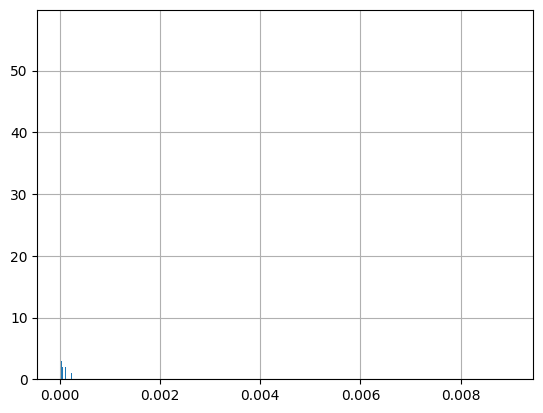

In [25]:
#* investigate
# get the value of the conductance at the peak
df = pd.DataFrame(columns=['seg_index','na_lower_bound','peak_value'])

for s in na_df[~pd.isnull(na_df.na_lower_bound)].seg_index.unique():
    inds = na_df[na_df.seg_index==s]['na_lower_bound'].astype(int).values # indices where gmax begins to be high


    L = np.split(gNaTa[:,s], inds) # list of gmaxes between indices

    X = reshape_pad(L) # make all timeframes in L have same length by appending nan to the end

    peak_vals = np.max(X[:,0:10], axis=1) # peak value of only the first 1 ms after crossing bound

    df = pd.concat((df,pd.DataFrame({'seg_index': s*np.ones((inds.shape[0],)).astype(int),
                                     'na_lower_bound': inds,
                                     'peak_value': peak_vals[1:]})))



print(df.shape)
print(df)
df.groupby('seg_index')['peak_value'].mean().hist() # plot
df_gb = df.groupby('seg_index')['na_lower_bound'].count().sort_values().reset_index() #count unique lower bounds
outliers = df_gb[df_gb.na_lower_bound>1000]['seg_index'].values
df_noout = df[(df.seg_index.isin(outliers))&(df.peak_value>0.006)]
na_df_new = pd.concat((df_noout[['seg_index','na_lower_bound','peak_value']],na_df.loc[~na_df.seg_index.isin(outliers),['seg_index','na_lower_bound']]))
na_df_new.to_csv('na_df.csv',index=False)

df.loc[df.seg_index==936,'peak_value'].hist(bins=np.arange(0.003,0.01,0.001))

In [26]:
na_df=na_df_new

In [27]:
na_df=na_df.reset_index(drop=True)

In [28]:
# print(na_df.loc[4,'na_lower_bound'])

In [29]:
# #could try to make this recursive in the case that the random choice fails

for i in na_df.seg_index.unique():
    seg = na_df.loc[i,'seg_index']
    if not pd.isnull(na_df.loc[i,'na_lower_bound']):
        spkt = int(na_df.loc[i,'na_lower_bound'])
        trace = gNaTa[spkt-10:spkt+10,seg]
        peak_value = np.max(trace)
        half_peak = peak_value/2
        # duration = np.arange(0,20)[trace>half_peak] + spkt - 10 #gave occasional error
        duration = np.arange(0,len(trace))[trace>half_peak] + spkt - 10
        na_df.loc[i,'duration_low'] = duration[0]
        na_df.loc[i,'duration_high'] = duration[-1]
        na_df.loc[i,'peak_value'] = peak_value
    else:
        na_df.loc[i,'duration_low'] = np.nan
        na_df.loc[i,'duration_high'] = np.nan
        na_df.loc[i,'peak_value'] = np.nan

In [30]:
na_df['duration'] = (na_df['duration_high'] - na_df['duration_low'] + 1)/10

In [31]:
segs_na_df = segs.join(na_df.set_index('seg_index')).reset_index()
# segs_na_df = segs.set_index('seg_index').join(na_df.set_index('seg_index')).reset_index()
# display(segs_na_df.Type.to_string())
# display(segs_na_df.Elec_distance.to_string())


segs_na_df = segs_na_df.fillna(value=np.nan)


# segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&(segs_na_df.Type=='apic')]

In [32]:
print(segs_na_df)

     index                             seg  seg index      p0 x3d     p0 y3d  \
0        0    L5PCtemplate[0].soma[0](0.5)          0   34.163384  17.621519   
1        1    L5PCtemplate[0].dend[0](0.5)          1   60.067916  24.460821   
2        2    L5PCtemplate[0].dend[1](0.5)          2   75.043081  18.176627   
3        3    L5PCtemplate[0].dend[2](0.5)          3  122.409150  46.734807   
4        4    L5PCtemplate[0].dend[3](0.5)          4   86.410004  19.889999   
..     ...                             ...        ...         ...        ...   
483    193  L5PCtemplate[0].apic[108](0.5)        193    1.757957  73.813991   
484    193  L5PCtemplate[0].apic[108](0.5)        193    1.757957  73.813991   
485    193  L5PCtemplate[0].apic[108](0.5)        193    1.757957  73.813991   
486    194    L5PCtemplate[0].axon[0](0.5)        194   45.725559  18.343678   
487    195    L5PCtemplate[0].axon[1](0.5)        195   45.725559  48.343678   

        p0 z3d    p0.5 x3d   p0.5 y3d  

In [33]:
segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                       (segs_na_df.Type=='dend')]['Elec_distance'].unique()

array([], dtype=float64)

In [34]:
segs_na_df[(segs_na_df.Type=='dend')]

,index,seg,seg index,p0 x3d,p0 y3d,p0 z3d,p0.5 x3d,p0.5 y3d,p0.5 z3d,p1 x3d,...,Elec_distance,segmentID,Distance,Elec DistanceQ,DistanceQ,na_lower_bound,peak_value,duration_low,duration_high,duration
1,1,L5PCtemplate[0].dend[0](0.5),1,60.067916,24.460821,-61.353874,66.929149,21.040891,-51.991813,73.790382,...,0.790003,1,12.100439,9.0,0.0,NaN,NaN,NaN,NaN,NaN
2,2,L5PCtemplate[0].dend[1](0.5),2,75.043081,18.176627,-44.915674,81.006490,20.137203,-40.647341,86.969898,...,0.534257,2,31.791976,7.0,1.0,NaN,NaN,NaN,NaN,NaN
3,3,L5PCtemplate[0].dend[2](0.5),3,122.409150,46.734807,47.312976,125.219392,65.340469,-26.140698,128.029634,...,0.090679,3,115.208601,3.0,7.0,NaN,NaN,NaN,NaN,NaN
4,4,L5PCtemplate[0].dend[3](0.5),4,86.410004,19.889999,-44.299999,88.896599,20.192551,-41.539216,91.383194,...,0.418009,4,43.110891,7.0,2.0,NaN,NaN,NaN,NaN,NaN
5,5,L5PCtemplate[0].dend[4](0.5),5,89.834455,13.122621,-45.705895,109.872517,9.458511,-4.141231,129.910578,...,0.125385,5,93.126621,4.0,6.0,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
80,80,L5PCtemplate[0].dend[79](0.5),80,34.038256,20.670000,-54.308283,28.211931,20.670000,-59.625083,22.385605,...,0.857077,80,7.887613,9.0,0.0,NaN,NaN,NaN,NaN,NaN
81,81,L5PCtemplate[0].dend[80](0.5),81,23.348647,27.516749,-60.383930,-0.834634,31.600465,-82.908192,-25.017914,...,0.071385,81,49.074627,2.0,2.0,NaN,NaN,NaN,NaN,NaN
82,82,L5PCtemplate[0].dend[81](0.5),82,22.145066,22.970209,-64.484819,16.732515,20.009496,-76.050098,11.319964,...,0.568610,82,28.883132,8.0,1.0,NaN,NaN,NaN,NaN,NaN
83,83,L5PCtemplate[0].dend[82](0.5),83,-29.049999,9.438713,-140.770945,-29.049999,-28.704780,-84.747666,-29.049999,...,0.029419,83,109.766651,0.0,6.0,NaN,NaN,NaN,NaN,NaN


In [35]:
#pd.set_option("display.max_rows", None, "display.max_columns", None)

#print(na_df)

In [36]:
spiketimes

array([ 104.1,  458.9,  546.4,  602.1,  728.4,  998.7, 1101.9, 1566.5,
       1820.3])

In [37]:
segs['Elec_distance']

0      1.000000
1      0.790003
2      0.534257
3      0.090679
4      0.418009
         ...   
191    0.357719
192    0.159107
193    0.168892
194    0.695620
195    0.398412
Name: Elec_distance, Length: 196, dtype: float64

In [42]:
def get_sta(segs_na_df, spiketimes):
    # Initializing dendritic and apical spike-triggered averages (STA) to zero matrices of shape (10, 39)
    na_dend = np.zeros((10, 39,))
    na_apic = np.zeros((10, 39,))

    # Try to calculate quantiles of electric distances for dendritic segments
    try:
        edges_dend=np.quantile(segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                        (segs_na_df.Type=='dend')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))
    except:
        edges_dend = [0]*100

    # Calculate quantiles of electric distances for apical segments
    edges_apic=np.quantile(segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                       (segs_na_df.Type=='apic')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))

    # Create an empty list to store actual spike times
    actual_spktimes = []
    prev_spiketime = 0
    for spiketime in np.sort(spiketimes):
        # exclude bursts
        if spiketime-prev_spiketime > 10:
            for e in np.arange(0,10):
                # Filter dendritic segments within specific electric distance ranges
                na_inds = segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                     (segs_na_df.Type=='dend')&
                                     (segs_na_df.Elec_distance>edges_dend[e])&
                                     (segs_na_df.Elec_distance<=edges_dend[e+1])]['na_lower_bound'].values.astype(int)

                # Calculate histogram of spike times around the current spike for dendritic segments
                x2, _ = np.histogram(na_inds/10,bins=np.arange(np.floor(spiketime)-20,np.floor(spiketime)+20,1))
                na_dend[e] += x2

                # Filter apical segments within specific electric distance ranges
                na_inds = segs_na_df[(~pd.isnull(segs_na_df.na_lower_bound))&
                                     (segs_na_df.Type=='apic')&
                                     (segs_na_df.Elec_distance>edges_apic[e])&
                                     (segs_na_df.Elec_distance<=edges_apic[e+1])]['na_lower_bound'].values.astype(int)

                # Calculate histogram of spike times around the current spike for apical segments
                x2, _ = np.histogram(na_inds/10,bins=np.arange(np.floor(spiketime)-20,np.floor(spiketime)+20,1))
                na_apic[e] += x2

            actual_spktimes.append(spiketime)
        prev_spiketime = spiketime

    return na_dend, na_apic

In [43]:
na_dend, na_apic = get_sta(segs_na_df, spiketimes)
rand_spktimes = np.sort(np.random.choice(np.arange(0,150000), spiketimes.shape[0]))
na_dend_rand, na_apic_rand = get_sta(segs_na_df, rand_spktimes)

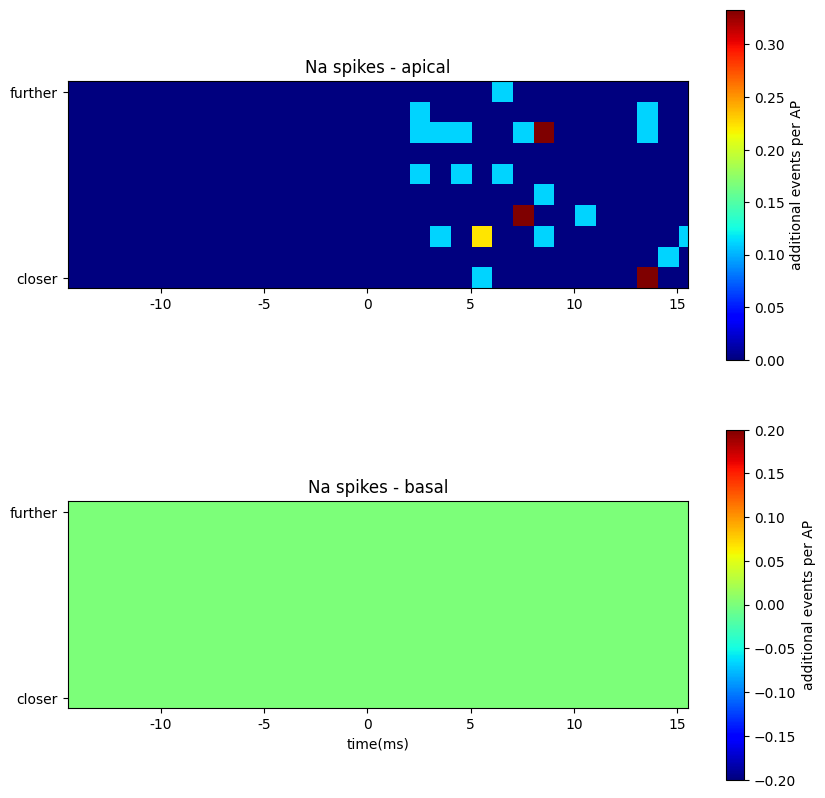

In [44]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('Na spikes - apical')
# plt.imshow((na_dend-na_dend_rand)/len(spiketimes),cmap='jet',vmin=-0.4, vmax=0.6)
plt.imshow((na_apic-na_apic_rand)/len(spiketimes),cmap='jet')
plt.colorbar(label='additional events per AP')
plt.xticks(ticks=np.arange(0,40,5)-0.5,labels=['{}'.format(i) for i in np.arange(-20,20,5)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.xlim(5,35)

plt.subplot(2,1,2)
plt.title('Na spikes - basal')
plt.imshow((na_dend-na_dend_rand)/len(spiketimes),cmap='jet',vmin=-0.2, vmax=0.2)
# plt.imshow((na_dend-na_dend_rand)/len(spktimes),cmap='jet')
plt.colorbar(label='additional events per AP')
plt.xticks(ticks=np.arange(0,40,5)-0.5,labels=['{}'.format(i) for i in np.arange(-20,20,5)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.xlabel('time(ms)')
plt.xlim(5,35)
plt.savefig(output_folder+'/NaSpikestoAP.png')

plt.show()

----------

In [68]:
ca_df = pd.DataFrame(columns=['segmentID','ca_lower_bound'])
lowery, uppery = 500, 1500
segs['segmentID'] = segs.index

CAsegIDs = segs[(segs.Type=='apic')&(segs['p0.5 y3d']>lowery)&(segs['p0.5 y3d']<uppery)]['segmentID']

for p in CAsegIDs:
    trace = icah[:,p]+\
                ical[:,p]+\
                ih[:,p]
    m = np.mean(trace)
    s = np.std(trace)

    legit_uc = voltage_criterion(data=v[:,p],v_thresh=-40, time_thresh=200)[1]
    legit_dc = voltage_criterion(data=v[:,p],v_thresh=-40, time_thresh=200)[-1]

    legit_uc_iso = legit_uc

    legit_dc_iso = legit_dc



    if (len(legit_uc_iso)!=0) & (np.min(trace)!=0):
        bnds, sum_curr = current_criterion(legit_uc_iso=legit_uc_iso,
                                           legit_dc_iso=legit_dc_iso,
                                           p=p,
                                           control_inmda=icah)
        ca_df = pd.concat([ca_df,pd.DataFrame({'segmentID':np.tile(p,len(bnds)),
                                               'ca_lower_bound':np.array(bnds).reshape(-1,2)[:,0],
                                               'ca_upper_bound':np.array(bnds).reshape(-1,2)[:,1],
                                               'mag':sum_curr})],axis=0, join='outer')

    else:
        ca_df = pd.concat([ca_df,pd.DataFrame({'segmentID':np.tile(p,1),
                                               'ca_lower_bound':np.nan,
                                               'ca_upper_bound':np.nan,
                                               'mag':np.nan})],axis=0, join='outer')

In [ ]:
#print(ca_df)

In [ ]:
if save_dfs==True:
    ca_df.to_csv(output_folder+'/'+'ca_df.csv')
    ca_df = pd.read_csv(output_folder+'/'+'ca_df.csv')

# durations

In [54]:
np.random.choice(segs[(segs['p0.5 y3d']<-50)&
     (segs['p0.5 y3d']>-100)&
     (segs['p0.5 x3d']>-50)&
     (segs['p0.5 x3d']<50)&
     (segs['Type']=='dend')]['segmentID'])

KeyError: ignored

## Plotting morphology as heat maps

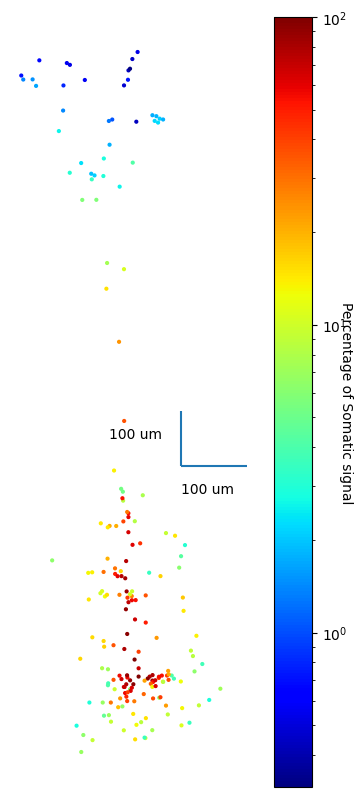

In [70]:
plt.figure(figsize=(4,10))
ax = plt.scatter(segs['p0.5 x3d'], segs['p0.5 y3d'],c=100*segs['Elec_distance'],s=4,cmap='jet', norm='log')
plt.vlines(110,400,500)
plt.text(0,450,'100 um')
plt.hlines(400,110,210)
plt.text(110,350,'100 um')
plt.xticks([])
plt.yticks([])
cbar = plt.colorbar()
cbar.ax.set_ylabel('Percentage of Somatic signal', rotation=270)

#ax2.ax.set_title('log(elec_distance)',rotation=270)
plt.box(False)
plt.savefig(output_folder+'/Elec_distance.png')

## Plotting morphology and voltage traces

In [ ]:
# x = ca_df[~pd.isnull(ca_df.ca_lower_bound)].reset_index()
# i = np.random.choice(x.index)

In [56]:
ca_df.reset_index(inplace=True)

In [57]:
ca_df

,index,segmentID,ca_lower_bound,ca_upper_bound,mag
0,0,122,88,336.0,-0.919103
1,1,122,1980,2442.0,-1.020238
2,2,122,3199,3450.0,-0.516013
3,3,122,4296,4699.0,-0.845217
4,4,122,5655,6221.0,-0.514827
...,...,...,...,...,...
280,15,159,15759,16031.0,-0.029868
281,16,159,16281,17274.0,-0.114891
282,17,159,17517,18398.0,-0.096829
283,18,159,18531,18708.0,-0.017145


In [60]:
for i in np.random.choice(ca_df[(ca_df.ca_lower_bound>20) & (ca_df.ca_lower_bound<1400000)].index,100):
    seg = ca_df.loc[i,'segmentID']
    if not pd.isnull(ca_df.loc[i,'ca_lower_bound']):
        spkt = int(ca_df.loc[i,'ca_lower_bound'])
        if spkt>100:

          trace = -(icah[spkt-100:spkt+200,seg] + \
                  ical[spkt-100:spkt+200,seg] + \
                  ih[spkt-100:spkt+200,seg])
          try:
            peak_value = np.max(trace) # may recieve error here if trace is empty. in that case, check segmentID and seg
          except:
            pdb.set_trace()
          half_peak = peak_value/2
          duration = np.arange(0,300)[trace>half_peak] + spkt - 10
          ca_df.loc[i,'duration_low'] = duration[0]
          ca_df.loc[i,'duration_high'] = duration[-1]
          ca_df.loc[i,'peak_value'] = peak_value
    else:
        ca_df.loc[i,'duration_low'] = np.nan
        ca_df.loc[i,'duration_high'] = np.nan
        ca_df.loc[i,'peak_value'] = np.nan

----------

In [61]:
segs_ca_df = segs.set_index('segmentID').join(ca_df.set_index('segmentID')).reset_index()

In [ ]:
# segs_ca_df['logElec_distance']=np.log(segs_ca_df['Elec_distance'])

In [71]:
def get_ca_sta(segs_ca_df, spktimes):

    ca_apic = np.zeros((10,27,))

    edges_apic=np.quantile(segs_ca_df[(~pd.isnull(segs_ca_df.ca_lower_bound))&
                                       (segs_ca_df.Type=='apic')]['Elec_distance'].unique(),np.arange(0,1.1,0.1)) #split apical segments into 10 groups with equally spaced electrotonic distance



    actual_spktimes = []
    c = 0
    for i in np.sort(spktimes):
        # excludes bursts
        if i-c > 10:
            for e in np.arange(0,10):
                ca_inds = segs_ca_df[(~pd.isnull(segs_ca_df.ca_lower_bound))&
                                     (segs_ca_df.Type=='apic')&
                                     (segs_ca_df.Elec_distance>edges_apic[e])&
                                     (segs_ca_df.Elec_distance<=edges_apic[e+1])]['ca_lower_bound'].values.astype(int) #get spikes within the electrotonic distance groups

                x2, _ = np.histogram(ca_inds/10,bins=np.arange(np.floor(i)-100,np.floor(i)+40,5)) #bin the spikes based on time
                ca_apic[e] += x2



            actual_spktimes.append(i)
        c = i
    return ca_apic

In [72]:
ca_apic = get_ca_sta(segs_ca_df, spiketimes)

In [73]:
rand_spktimes = np.sort(np.random.choice(np.arange(0,150000), spiketimes.shape[0]))
ca_apic_rand = get_ca_sta(segs_ca_df, rand_spktimes)

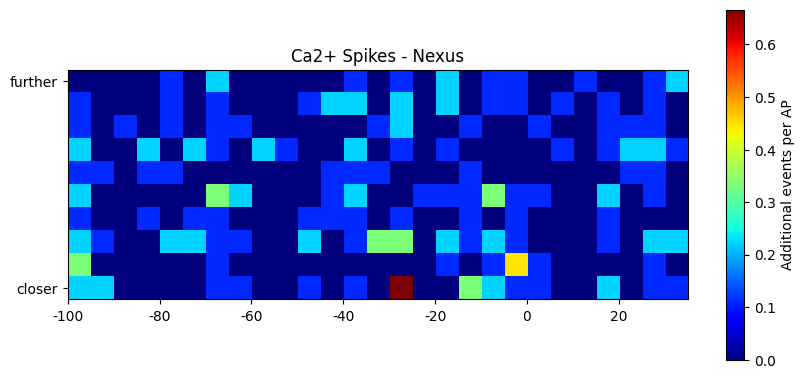

In [74]:
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('Ca2+ Spikes - Nexus')
plt.imshow((ca_apic-ca_apic_rand)/len(spiketimes),cmap='jet')
# plt.imshow((ca_apic-ca_apic_rand)/len(spktimes),cmap='jet',vmin=-1.5,vmax=1.5)
# plt.imshow((ca_apic-ca_apic_rand)/len(spiketimes),cmap='jet',vmin=None,vmax=None)
# plt.xticks(ticks=np.arange(0,40,2)-0.5,labels=['{}'.format(i) for i in np.arange(-20,20,2)])
plt.xticks(ticks=np.arange(0,26,4)-0.5,labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.colorbar(label='Additional events per AP')
# plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.savefig(output_folder+'/DetailedCaSpikes.png')
plt.show()

----------------------

In [ ]:
#apic_exc = segs_conns[(segs_conns['Source Population']=='exc_stim')&(segs_conns.Type=='apic')].groupby('segmentID')['Conductance'].sum().reset_index()

#basal_exc = segs_conns[(segs_conns['Source Population']=='exc_stim')&(segs_conns.Type=='dend')].groupby('segmentID')['Conductance'].sum().reset_index()


In [75]:
nmda_df = pd.DataFrame(columns=['segmentID','nmda_lower_bound', 'nmda_upper_bound', 'mag'])
for p in segs[(segs.Type=='dend')|(segs.Type=='apic')].index: #(segs.Type=='dend')|(segs.Type=='apic')
    #print(p)
    legit_uc = voltage_criterion(data=v[:,p],v_thresh=-40, time_thresh=260)[1]
    legit_dc = voltage_criterion(data=v[:,p],v_thresh=-40, time_thresh=260)[-1]

    legit_uc_iso = legit_uc

    legit_dc_iso = legit_dc

    #print(legit_uc)
    #print(legit_dc)

    if (len(legit_uc_iso)!=0) & (np.min(inmda[:,p])!=0):
        bnds, sum_curr = current_criterion(legit_uc_iso=legit_uc_iso,
                                           legit_dc_iso=legit_dc_iso,
                                           p=p,
                                           control_inmda=inmda)


        # nmda_df = nmda_df.append(pd.DataFrame({'segmentID':np.tile(p,len(bnds)),
        #                                        'nmda_lower_bound':np.array(bnds).reshape(-1,2)[:,0],
        #                                        'nmda_upper_bound':np.array(bnds).reshape(-1,2)[:,1],
        #                                        'mag':sum_curr}))
        nmda_df = pd.concat([nmda_df,pd.DataFrame({'segmentID':np.tile(p,len(bnds)),
                                               'nmda_lower_bound':np.array(bnds).reshape(-1,2)[:,0],
                                               'nmda_upper_bound':np.array(bnds).reshape(-1,2)[:,1],
                                               'mag':sum_curr})],axis=0, join='outer')
        #print(nmda_df.mag)

    else:
        #print('else')
        # nmda_df = nmda_df.append(pd.DataFrame({'segmentID':np.tile(p,1),
        #                                        'nmda_lower_bound':np.nan,
        #                                        'nmda_upper_bound':np.nan,
        #                                        'mag':np.nan}))
        nmda_df = pd.concat([nmda_df,pd.DataFrame({'segmentID':np.tile(p,1),
                                               'nmda_lower_bound':np.nan,
                                               'nmda_upper_bound':np.nan,
                                               'mag':np.nan})],axis=0, join='outer')


#display(nmda_df.mag.to_string())


#min(nmda_df.mag)

In [76]:
nmda_df['duration'] = nmda_df['nmda_upper_bound'] - nmda_df['nmda_lower_bound']

In [ ]:
if save_dfs==True:
    nmda_df.to_csv(output_folder+'/'+'nmda_df.csv')
    nmda_df = pd.read_csv(output_folder+'/'+'nmda_df.csv')

In [ ]:
#mda_df.mag <= -0.000000001

In [ ]:
#segs_nmda_df[:]

In [ ]:
#nmda_df.rename(columns={'seg_id':'segmentID'},inplace=True)

In [77]:
segs_nmda_df = segs.join(nmda_df.set_index('segmentID')).reset_index()

In [78]:
segs_nmda_df[(segs_nmda_df.mag<-0.0001)&
                                  (segs_nmda_df.Type=='dend')]

,index,seg,seg index,p0 x3d,p0 y3d,p0 z3d,p0.5 x3d,p0.5 y3d,p0.5 z3d,p1 x3d,...,netcon_SA_density_per_seg,Elec_distance,segmentID,Distance,Elec DistanceQ,DistanceQ,nmda_lower_bound,nmda_upper_bound,mag,duration
3,3,L5PCtemplate[0].dend[2](0.5),3,122.409150,46.734807,47.312976,125.219392,65.340469,-26.140698,128.029634,...,"{'exc': 0.9510291497601382, 'inh': 0.174355344...",0.090679,3,115.208601,3,7,11315,11434,-1019.128878,119
6,6,L5PCtemplate[0].dend[5](0.5),6,81.836153,34.973080,-37.586238,169.944181,-3.649640,-46.034921,258.052208,...,"{'exc': 1.1884863685616842, 'inh': 0.166010794...",0.072225,6,143.410543,2,9,1674,1785,-974.033285,111
7,6,L5PCtemplate[0].dend[5](0.5),6,81.836153,34.973080,-37.586238,169.944181,-3.649640,-46.034921,258.052208,...,"{'exc': 1.1884863685616842, 'inh': 0.166010794...",0.072225,6,143.410543,2,9,3828,3989,-1728.538211,161
15,14,L5PCtemplate[0].dend[13](0.5),14,80.492425,-24.000000,-88.793069,152.996014,-24.000000,-102.184145,225.499602,...,"{'exc': 1.0550426012490102, 'inh': 0.168806816...",0.028633,14,136.850509,0,8,994,1346,-1298.386381,352
16,14,L5PCtemplate[0].dend[13](0.5),14,80.492425,-24.000000,-88.793069,152.996014,-24.000000,-102.184145,225.499602,...,"{'exc': 1.0550426012490102, 'inh': 0.168806816...",0.028633,14,136.850509,0,8,2790,2843,-275.773091,53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
135,83,L5PCtemplate[0].dend[82](0.5),83,-29.049999,9.438713,-140.770945,-29.049999,-28.704780,-84.747666,-29.049999,...,"{'exc': 1.4170551106752627, 'inh': 0.178144071...",0.029419,83,109.766651,0,6,10404,10493,-692.406878,89
136,83,L5PCtemplate[0].dend[82](0.5),83,-29.049999,9.438713,-140.770945,-29.049999,-28.704780,-84.747666,-29.049999,...,"{'exc': 1.4170551106752627, 'inh': 0.178144071...",0.029419,83,109.766651,0,6,10761,10824,-421.266668,63
137,83,L5PCtemplate[0].dend[82](0.5),83,-29.049999,9.438713,-140.770945,-29.049999,-28.704780,-84.747666,-29.049999,...,"{'exc': 1.4170551106752627, 'inh': 0.178144071...",0.029419,83,109.766651,0,6,11784,11809,-123.690245,25
138,83,L5PCtemplate[0].dend[82](0.5),83,-29.049999,9.438713,-140.770945,-29.049999,-28.704780,-84.747666,-29.049999,...,"{'exc': 1.4170551106752627, 'inh': 0.178144071...",0.029419,83,109.766651,0,6,14155,14160,-37.885716,5


In [ ]:
#min(segs_nmda_df.mag)

In [ ]:
#segs_nmda_df[(segs_nmda_df.mag<-0.0001)]

In [79]:
def get_nmda_sta(segs_nmda_df, spktimes):
    nmda_dend = np.zeros((10,27,))
    nmda_apic = np.zeros((10,27,))

    edges_dend=np.quantile(segs_nmda_df[(segs_nmda_df.mag<-0.0001)&
                                  (segs_nmda_df.Type=='dend')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))
    edges_apic=np.quantile(segs_nmda_df[(segs_nmda_df.mag<-0.00001)&
                                   (segs_nmda_df.Type=='apic')]['Elec_distance'].unique(),np.arange(0,1.1,0.1))

    actual_spktimes = []
    c = 0
    for i in np.sort(spktimes):
        # excludes bursts
        if i-c > 10:
            for e in np.arange(0,10):
                nmda_inds = segs_nmda_df[(segs_nmda_df.mag<-0.0001)&
                                     (segs_nmda_df.Type=='dend')&
                                     (segs_nmda_df.Elec_distance>edges_dend[e])&
                                     (segs_nmda_df.Elec_distance<=edges_dend[e+1])]['nmda_lower_bound'].values.astype(int)

                x2, _ = np.histogram(nmda_inds/10,bins=np.arange(np.floor(i)-100,np.floor(i)+40,5))
                nmda_dend[e] += x2

                nmda_inds = segs_nmda_df[(segs_nmda_df.mag<-0.0001)&
                                     (segs_nmda_df.Type=='apic')&
                                     (segs_nmda_df.Elec_distance>edges_apic[e])&
                                     (segs_nmda_df.Elec_distance<=edges_apic[e+1])]['nmda_lower_bound'].values.astype(int)

                x2, _ = np.histogram(nmda_inds/10,bins=np.arange(np.floor(i)-100,np.floor(i)+40,5))
                nmda_apic[e] += x2

            actual_spktimes.append(i)
        c = i

    return nmda_dend, nmda_apic

In [80]:
nmda_dend, nmda_apic = get_nmda_sta(segs_nmda_df, spiketimes)

In [81]:
rand_spktimes = np.sort(np.random.choice(np.arange(0,150000), spiketimes.shape[0]))

In [82]:
nmda_dend_rand, nmda_apic_rand = get_nmda_sta(segs_nmda_df, rand_spktimes)

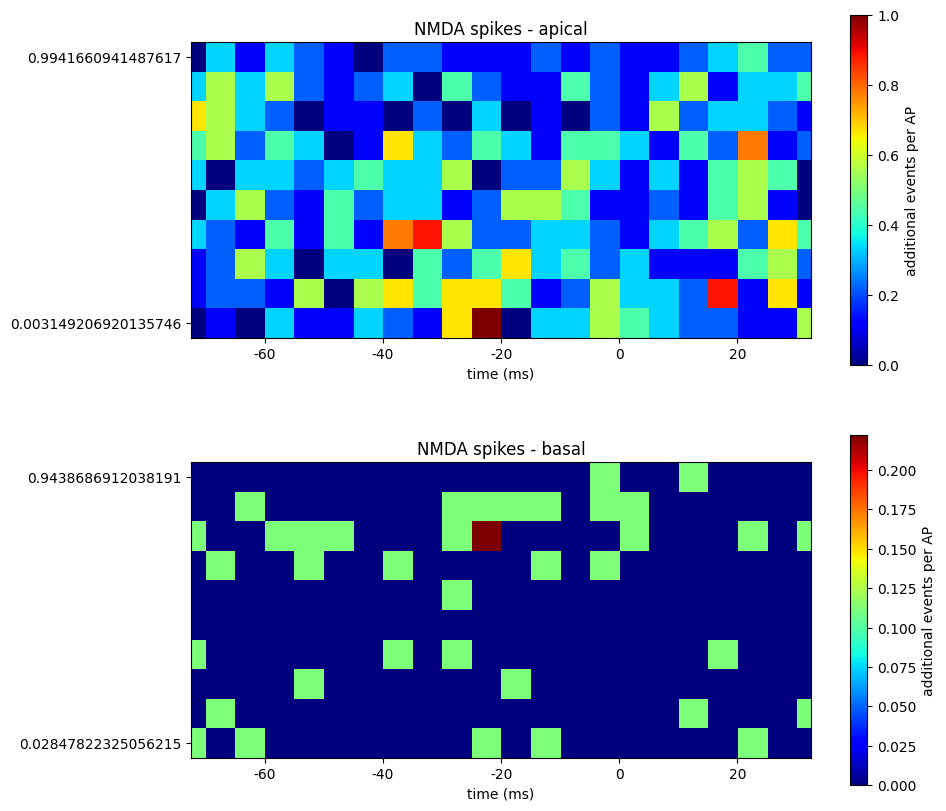

In [84]:
plt.figure(num=3,figsize=(10,10))
plt.subplot(2,1,1)
plt.title('NMDA spikes - apical')
plt.imshow((nmda_apic-nmda_apic_rand)/len(spiketimes),cmap='jet')
# plt.imshow((nmda_apic-nmda_apic_rand)/len(spktimes),cmap='jet',vmin=-0.6,vmax=0.6)
plt.xticks(ticks=np.arange(0,26,4)-0.5,labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.yticks(ticks=[0,9],labels=[str(segs_nmda_df[segs_nmda_df.Type=='apic']['Elec_distance'].max()),str(segs_nmda_df[segs_nmda_df.Type=='apic']['Elec_distance'].min())])
plt.colorbar(label='additional events per AP')
plt.xlabel('time (ms)')
plt.xlim(5,26)

plt.subplot(2,1,2)
plt.title('NMDA spikes - basal')
plt.imshow((nmda_dend-nmda_dend_rand)/len(spiketimes),cmap='jet')
# plt.imshow((nmda_dend-nmda_dend_rand)/len(spktimes),cmap='jet', vmin=-0.6, vmax=0.6)
plt.xticks(ticks=np.arange(0,26,4)-0.5,labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.yticks(ticks=[0,9],labels=[str(segs_nmda_df[segs_nmda_df.Type=='dend']['Elec_distance'].max()),str(segs_nmda_df[segs_nmda_df.Type=='dend']['Elec_distance'].min())])
plt.colorbar(label='additional events per AP')
plt.xlim(5,26)

plt.xlabel('time (ms)')
plt.savefig(output_folder+'/NMDASpikes.png')
plt.show(plt.figure(num=3)) #test

In [85]:
sum(segs_nmda_df['segmentID'][segs_nmda_df.Type=='dend'])

6652

In [ ]:
segs.Type

In [87]:
# i believe this was plotting synapse density

def plot_colorfield(color_field=str,vmin = None,vmax = None,lw=1):
    ax = plt.figure(figsize=(10,16))
    import matplotlib
    from matplotlib.colors import Normalize
    cmap = matplotlib.cm.get_cmap('jet')
    norm = matplotlib.colors.Normalize(vmin = vmin, vmax = vmax)

    for i in segs[segs.Type=='apic']['sec index'].unique():
        section_L = segs[(segs.Type=='apic')&(segs['sec index']==i)]['sec L'].unique()[0]
        plt.plot(segs[(segs.Type=='apic')&(segs['sec index']==i)]['p0.5 x3d'],
                segs[(segs.Type=='apic')&(segs['sec index']==i)]['p0.5 y3d'],
                color=cmap(norm(segs[(segs.Type=='apic')&(segs['sec index']==i)][color_field].sum()/section_L)),
                linewidth = lw*segs[(segs.Type=='apic')&(segs['sec index']==i)]['sec diam'].unique())

    for i in segs[segs.Type=='dend']['sec index'].unique():
        section_L = segs[(segs.Type=='dend')&(segs['sec index']==i)]['Section_L'].unique()[0]
        plt.plot(segs[(segs.Type=='dend')&(segs['sec index']==i)]['p0.5 x3d'],
                segs[(segs.Type=='dend')&(segs['sec index']==i)]['p0.5 y3d'],
                color=cmap(norm(segs[(segs.Type=='dend')&(segs['sec index']==i)][color_field].sum()/section_L)),
                linewidth = lw*segs[(segs.Type=='dend')&(segs['sec index']==i)]['sec diam'].unique())
    #
    #
    plt.scatter(segs[(segs.Type=='soma')&(segs['sec index']==0)].loc[0,'p0.5 x3d'],
            segs[(segs.Type=='soma')&(segs['sec index']==0)].loc[0,'p0.5 y3d'],color='k',s=100)
    plt.vlines(110,400,500)
    plt.text(0,450,'100 um')
    plt.hlines(400,110,210)
    plt.text(110,350,'100 um')
    plt.xticks([])
    plt.yticks([])
    cbar = plt.colorbar(matplotlib.cm.ScalarMappable(norm=norm, cmap=cmap))
    #cbar.ax.set_ylabel('log(elec_distance)', rotation=270)

    #ax2.ax.set_title('log(elec_distance)',rotation=270)
    plt.box(False)
    plt.savefig(output_folder+str(color_field)+'.png')

plot_colorfield(color_field='num_syns_exc',vmax=2.2,vmin=0,lw=5)
plot_colorfield(color_field='num_syns_inh',vmax=0.3,vmin=0,lw=5)

<ipython-input-87-cf621ee1d578>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = matplotlib.cm.get_cmap('jet')


KeyError: ignored

<Figure size 1000x1600 with 0 Axes>

In [88]:
#NMDA effect on calcium
#ca_spktimes = segs_ca_df[segs_ca_df.segmentID==1738]['ca_lower_bound']/10
def get_nmda_sta_calcium(segs_nmda_df, spktimes):
    nmda_dend = np.zeros((10,27,))
    nmda_apic = np.zeros((10,27,))

    edges_dend=np.quantile(segs_nmda_df[(segs_nmda_df.Type=='dend')]['Elec_distance_nexus'].unique(),np.arange(0,1.1,0.1))
    edges_apic=np.quantile(segs_nmda_df[(segs_nmda_df.Type=='apic')]['Elec_distance_nexus'].unique(),np.arange(0,1.1,0.1))

    actual_spktimes = []
    c = 0
    for i in np.sort(spktimes):
        # excludes bursts
        if i-c > 10:
            for e in np.arange(0,10):
                nmda_inds = segs_nmda_df[(segs_nmda_df.mag<-0.1)&
                                     (segs_nmda_df.Type=='dend')&
                                     (segs_nmda_df.Elec_distance_nexus>edges_dend[e])&
                                     (segs_nmda_df.Elec_distance_nexus<=edges_dend[e+1])]['nmda_lower_bound'].values.astype(int)

                x2, _ = np.histogram(nmda_inds/10,bins=np.arange(np.floor(i)-100,np.floor(i)+40,5))
                nmda_dend[e] += x2

                nmda_inds = segs_nmda_df[(segs_nmda_df.mag<-0.1)&
                                     (segs_nmda_df.Type=='apic')&
                                     (segs_nmda_df.Elec_distance_nexus>edges_apic[e])&
                                     (segs_nmda_df.Elec_distance_nexus<=edges_apic[e+1])]['nmda_lower_bound'].values.astype(int)

                x2, _ = np.histogram(nmda_inds/10,bins=np.arange(np.floor(i)-100,np.floor(i)+40,5))
                nmda_apic[e] += x2

            actual_spktimes.append(i)
        c = i

    return nmda_dend, nmda_apic
edges_apic=np.quantile(segs_nmda_df[(segs_nmda_df.Type=='apic')]['Elec_distance_nexus'].unique(),np.arange(0,1.1,0.1))


KeyError: ignored

In [ ]:
ca_spktimes = segs_ca_df[(segs_ca_df['Sec Name']=='disttrunk')]['ca_lower_bound']/10

In [ ]:
ca_spktimes_nodupes = np.sort(ca_spktimes[1:])[np.diff(np.sort(ca_spktimes))>100]
nmda_dend, nmda_apic = get_nmda_sta_calcium(segs_nmda_df,ca_spktimes_nodupes)
rand_spktimes = np.sort(np.random.choice(np.arange(0,150000), ca_spktimes_nodupes.shape[0]))
nmda_dend_rand, nmda_apic_rand = get_nmda_sta_calcium(segs_nmda_df, rand_spktimes)
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
plt.title('NMDA spikes - apical')
x = (nmda_apic-nmda_apic_rand)/ca_spktimes_nodupes.shape[0]
# plt.imshow(x,cmap='jet',vmin = -1, vmax = 5)
plt.imshow(x,cmap='jet',vmin = None, vmax = None)
plt.xticks(ticks=np.arange(0,26,4)+0.5,labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per Ca2+ spike')
plt.xlabel('time (ms)')
plt.xlim(5,26)

plt.subplot(2,1,2)
plt.title('NMDA spikes - basal')
x = (nmda_dend-nmda_dend_rand)/ca_spktimes_nodupes.shape[0]
plt.imshow(x,cmap='jet',vmin = -1, vmax = 5)
plt.xticks(ticks=np.arange(0,26,4)+0.5,labels=['{}'.format(i) for i in np.arange(-100,40,20)])
plt.yticks(ticks=[0,9],labels=['further','closer'])
plt.colorbar(label='additional events per Ca2+ spike')
plt.xlim(5,26)

plt.xlabel('time (ms)')
plt.savefig(output_folder+'/nmdaspikes.png')
plt.show()

In [ ]:
segs_nmda_df['Elec_distance_nexus']

In [ ]:
# print(segs_nmda_df[segs_nmda_df['nmda_lower_bound']>8000]) #get every index where nmda_lower_bound>8000
# print(segs[segs['Seg_L']>5]) #show segs with this condition
totallength=sum(segs['seg L'])

NameError: ignored

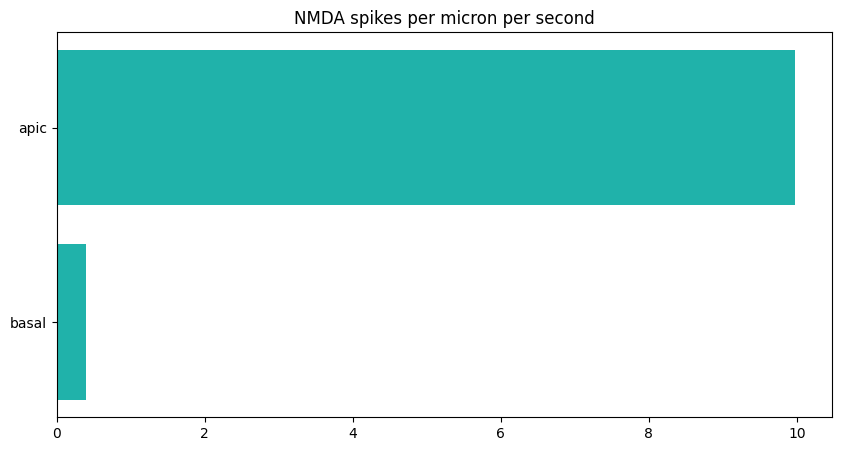

In [90]:
total_basal_nmda = sum(segs_nmda_df['segmentID'][segs_nmda_df.Type=='dend'][~pd.isnull(segs_nmda_df.mag)])
# num_basal_seg = len(segs[segs.Type=='dend'])
basal_length = sum(segs['seg L'][segs.Type=='dend'])

total_apic_nmda = sum(segs_nmda_df['segmentID'][segs_nmda_df.Type=='apic'][~pd.isnull(segs_nmda_df.mag)])
# num_apic_seg = len(segs[segs.Type=='apic'])
apic_length = sum(segs['seg L'][segs.Type=='apic'])

# apic_nmda_perSeg_perSec = (total_apic_nmda / num_apic_seg)/(tstop/dt)
# basal_ndma_perSeg_perSec = (total_basal_nmda / num_basal_seg)/(tstop/dt)
apic_nmda_perUM_perSec = (total_apic_nmda / apic_length)/(tstop/1000) # Can divide by x microns to get per X microns
basal_ndma_perUM_perSec = (total_basal_nmda / basal_length)/(tstop/1000) # Can divide by x microns to get per X microns

# data = {'basal':basal_ndma_perSeg_perSec, 'apic':apic_nmda_perSeg_perSec}
data = {'basal':basal_ndma_perUM_perSec, 'apic':apic_nmda_perUM_perSec}
group = list(data.keys())
value = list(data.values())

fig = plt.figure(figsize = (10, 5))
# plt.title('NMDA spikes per segment per second')
plt.title('NMDA spikes per micron per second')


# creating the bar plot
plt.barh(group, value, color ='lightseagreen')
plt.savefig(output_folder+'/NMDASpikesPerUmPerSec.png')

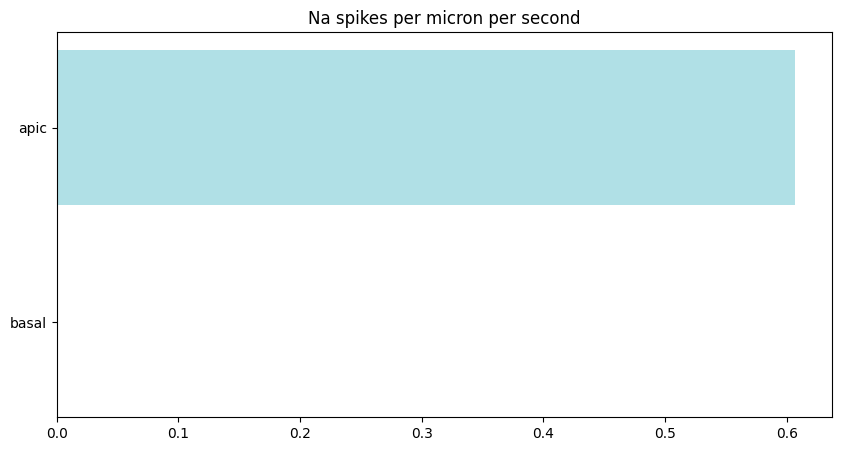

In [91]:
total_basal_na = sum(segs_na_df['segmentID'][segs_na_df.Type=='dend'][~pd.isnull(segs_na_df.duration_high)])
# num_basal_seg = len(segs[segs.Type=='dend'])
basal_length = sum(segs['seg L'][segs.Type=='dend'])

total_apic_na = sum(segs_na_df['segmentID'][segs_na_df.Type=='apic'][~pd.isnull(segs_na_df.duration_high)])
# num_apic_seg = len(segs[segs.Type=='apic'])
apic_length = sum(segs['seg L'][segs.Type=='apic'])

# apic_na_perSeg_perSec = (total_apic_na / num_apic_seg)/(tstop/dt)
# basal_na_perSeg_perSec = (total_basal_na / num_basal_seg)/(tstop/dt)
apic_na_perUM_perSec = (total_apic_na / apic_length)/(tstop/1000) # Can divide by x microns to get per X microns
basal_na_perUM_perSec = (total_basal_na / basal_length)/(tstop/1000) # Can divide by x microns to get per X microns

# data = {'basal':basal_na_perSeg_perSec, 'apic':apic_na_perSeg_perSec}
data = {'basal':basal_na_perUM_perSec, 'apic':apic_na_perUM_perSec}
group = list(data.keys())
value = list(data.values())

fig = plt.figure(figsize = (10, 5))
# plt.title('Na spikes per segment per second')
plt.title('Na spikes per micron per second')


# creating the bar plot
plt.barh(group, value, color ='powderblue')
plt.savefig(output_folder+'/NASpikesPerUmPerSec.png')

0


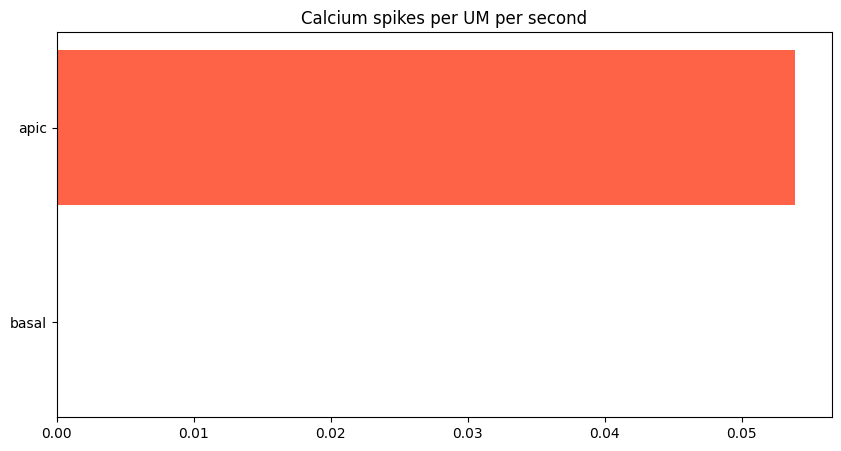

In [92]:
total_basal_ca = sum(segs_ca_df['index'][segs_ca_df.Type=='dend'][~pd.isnull(segs_ca_df.duration_high)])
# num_basal_seg = len(segs[segs.Type=='dend'])
basal_length = sum(segs['seg L'][segs.Type=='dend'])

print(total_basal_ca)

total_apic_ca = sum(segs_ca_df['index'][segs_ca_df.Type=='apic'][~pd.isnull(segs_ca_df.duration_high)])
# num_apic_seg = len(segs[segs.Type=='apic'])
apic_length = sum(segs['seg L'][segs.Type=='apic'])

# apic_ca_perSeg_perSec = (total_apic_ca / num_apic_seg)(tstop/dt)
# basal_ca_perSeg_perSec = (total_basal_ca / num_basal_seg)(tstop/dt)

apic_ca_perUM_perSec = (total_apic_ca / apic_length)/(tstop/1000) # Can divide by x microns to get per X microns
basal_ca_perUM_perSec = (total_basal_ca / basal_length)/(tstop/1000) # Can divide by x microns to get per X microns


# data = {'basal':basal_ca_perSeg_perSec, 'apic':apic_ca_perSeg_perSec}
data = {'basal':basal_ca_perUM_perSec, 'apic':apic_ca_perUM_perSec}
group = list(data.keys())
value = list(data.values())

fig = plt.figure(figsize = (10, 5))

# plt.title('Calcium spikes per segment per second')
plt.title('Calcium spikes per UM per second')


# creating the bar plot
plt.barh(group, value, color ='tomato')

plt.savefig(output_folder+'/CaSpikesPerUmPerSec.png')

In [ ]:
# segs.head() # segs does not have number of spikes
# print(segs_ca_df)

In [ ]:
# segs_ca_df[~pd.isnull(segs_ca_df.duration_high)].head()
segs_ca_df.head()

In [ ]:
all_ca=pd.DataFrame()
all_ca['NumSpikes'] = segs_ca_df['index'][~pd.isnull(segs_ca_df.duration_high)]
# print(segs_ca_df[~pd.isnull(segs_ca_df.duration_high)])
print(all_ca) # segment id and number of spikes
# print(sum(all_ca))
# plt.figure(figsize=(4,10))
# ax = plt.scatter(segs['Coord X'], segs['Coord Y'],c=all_ca)
# plt.vlines(110,400,500)
# plt.text(0,450,'100 um')
# plt.hlines(400,110,210)
# plt.text(110,350,'100 um')
# plt.xticks([])
# plt.yticks([])
# cbar = plt.colorbar()
# cbar.ax.set_ylabel('log(elec_distance)', rotation=270)

# #ax2.ax.set_title('log(elec_distance)',rotation=270)
# plt.box(False)
# plt.savefig('Elec_distance.png')
# # all_ca_perUM_perSec = (all_ca / segs['Seg_L'])/(tstop/dt) # Can divide by x microns to get per X microns
# # # print(all_ca_perUM_perSec)
# # for i in range(len(all_ca_perUM_perSec)):
# #     if np.isnan(all_ca_perUM_perSec[i])==True:
# #         all_ca_perUM_perSec[i]=0
# # print(all_ca_perUM_perSec)

In [ ]:
for i in np.arange(0,10):
    plt.plot(np.arange(-40,95,5),nmda_dend[i]/np.sum(nmda_dend[i]))


In [ ]:
# segs_conns[(segs_conns['Sec ID']==80) & (segs_conns.Type=='dend')]['Source Population'].value_counts()

(-150.0, 150.0)

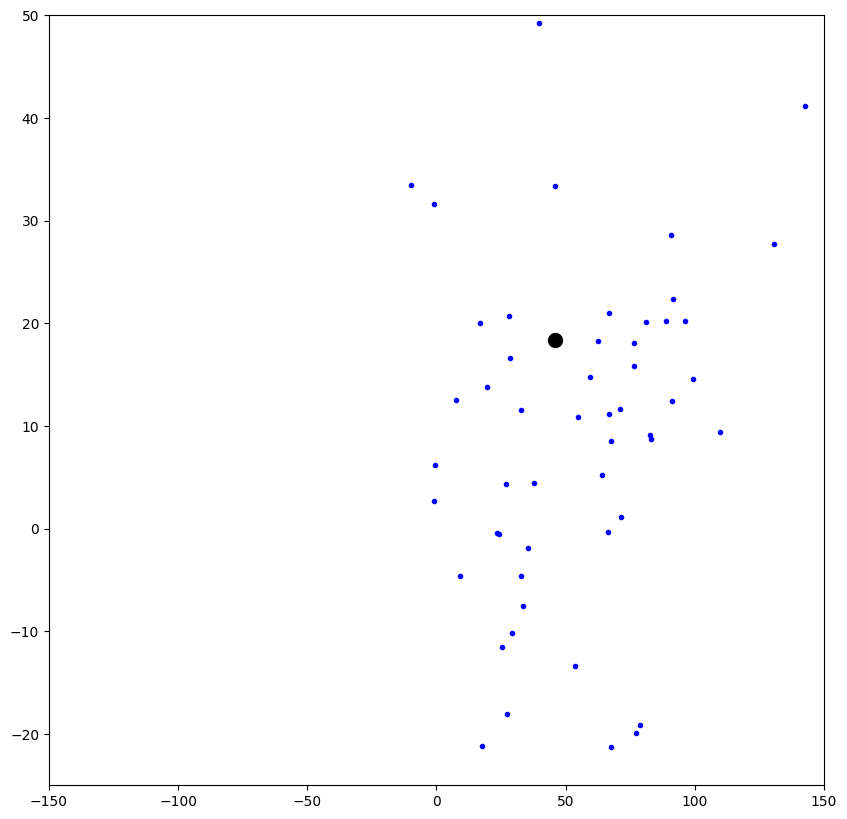

In [93]:
plt.figure(figsize=(10,10))
ind = 55
plt.plot(segs['p0.5 x3d'], segs['p0.5 y3d'], 'b.')
plt.plot(segs.loc[0,'p0.5 x3d'], segs.loc[0,'p0.5 y3d'], 'k.',markersize=20)

plt.plot(segs.loc[ind,'p0.5 x3d'], segs.loc[ind,'p0.5 y3d'], 'r*',markersize=20)

# for i in segs_conns[(segs_conns.Type=='dend')&(segs_conns['Sec ID']==2)]['Sec ID'].unique():
#     plt.plot(segs[(segs['Sec ID']==i)&(segs['Type']=='dend')]['Coord X'],
#              segs[(segs['Sec ID']==i)&(segs['Type']=='dend')]['Coord Y'],color='r')

#for i in segs_conns[(segs_conns.Type=='dend')&(segs_conns['Sec ID']==7)]['Sec ID'].unique():
#    plt.plot(segs[(segs['Sec ID']==i)&(segs['Type']=='dend')]['Coord X'],
#             segs[(segs['Sec ID']==i)&(segs['Type']=='dend')]['Coord Y'],color='c')

#plt.plot(segs[segs.segmentID==119]['Coord X'], segs[segs.segmentID==119]['Coord Y'],'r*',markersize=14)
#plt.plot(segs[segs.segmentID==110]['Coord X'], segs[segs.segmentID==110]['Coord Y'],'r*',markersize=14)
#plt.plot(segs[segs.segmentID==103]['Coord X'], segs[segs.segmentID==103]['Coord Y'],'r*',markersize=14)

#plt.plot(segs[segs.segmentID==134]['Coord X'], segs[segs.segmentID==134]['Coord Y'],'c*',markersize=14)
plt.ylim(-25,50)
plt.xlim(-150,150)

In [ ]:
# plt.figure(figsize=(10,10))
# plt.plot(f['report']['biophysical']['data'][:,119],color='b')
# plt.plot(f['report']['biophysical']['data'][:,110],color='b',alpha=0.5)
# plt.plot(f['report']['biophysical']['data'][:,104],color='b',alpha=0.1)

# plt.plot(f['report']['biophysical']['data'][:,134],color='c',alpha=1)
# plt.plot(f['report']['biophysical']['data'][:,0],'k')
# plt.twinx()
# plt.plot(h['report']['biophysical']['data'][:,119],color='r')
# plt.plot(h['report']['biophysical']['data'][:,110],color='r',alpha=0.5)
# plt.plot(h['report']['biophysical']['data'][:,103],color='r',alpha=0.1)

# plt.xlim(526519-100,526519+1000)

In [94]:
nmda2 = np.zeros((79,))
try:
  for i in spiketimes:
      nmda_inds2 = np.sort(segs_nmda_df[(segs_nmda_df.Degrees<=3)&
              (~pd.isnull(segs_nmda_df.nmda_lower_bound))&
              (segs_nmda_df.mag<-0.1)&
                  (segs_nmda_df.Type=='dend')]['nmda_lower_bound'].values.astype(int))

      x2, _ = np.histogram(nmda_inds2/10,bins=np.arange(i-40,i+40,1))
      nmda2 += x2
except:
  print('segs_nmda_df "DataFrame" object has no attribute "Degrees"')

    #na_inds3 = segs_na_df[(segs_na_df.Degrees==3)&(~pd.isnull(segs_na_df.na_lower_bound))]['na_lower_bound'].values.astype(int)
    #x3, _ = np.histogram(na_inds3/10,bins=np.arange(i-20,i+20,1))
    #na3 += x3

    #na_inds4 = segs_na_df[(segs_na_df.Degrees==4)&(~pd.isnull(segs_na_df.na_lower_bound))]['na_lower_bound'].values.astype(int)
    #x4, _ = np.histogram(na_inds4/10,bins=np.arange(i-20,i+20,1))
    #na4 += x4

    #na_inds5 = segs_na_df[(segs_na_df.Degrees==5)&(~pd.isnull(segs_na_df.na_lower_bound))]['na_lower_bound'].values.astype(int)
    #x5, _ = np.histogram(na_inds5/10,bins=np.arange(i-20,i+20,1))
    #na5 += x5


segs_nmda_df "DataFrame" object has no attribute "Degrees"


In [ ]:
plt.plot(nmda2)

In [ ]:
segs_ca_df.head()
# segs_na_df.head()
# segs_nmda_df.head()

In [ ]:
segs.head()

In [ ]:
#calculate segment spikes per second


In [ ]:
# import matplotlib
# font = {'family' : 'normal',
#         'weight' : 'normal',
#         'size'   : 16}

# matplotlib.rc('font', **font)

# ind = 1139
# plt.figure(figsize=(12,10))
# plt.plot(np.arange(0,60000,.1),f['report']['biophysical']['data'][:,ind],color='b',label='dend voltage')
# plt.plot(np.arange(0,60000,.1),f['report']['biophysical']['data'][:,0],color='k',alpha=0.3,label='soma voltage')
# plt.legend(loc='lower left')
# plt.hlines(-40,0,60000,linestyle='dashed')
# plt.ylabel('voltage (mV)')
# plt.ylim(-85,25)
# plt.xlabel('time (ms)')
# plt.twinx()
# plt.plot(np.arange(0,60000,.1),h['report']['biophysical']['data'][:,ind],color='r',label='inmda dend')
# plt.legend(loc='upper right')
# plt.plot(np.arange(0,60000,.1)[nmda_df[nmda_df.seg_id==ind]['nmda_lower_bound'].values.astype(int)],
#          h['report']['biophysical']['data'][nmda_df[nmda_df.seg_id==ind]['nmda_lower_bound'].values.astype(int),ind],'m*',markersize=20)
# plt.plot(np.arange(0,60000,.1)[nmda_df[nmda_df.seg_id==ind]['nmda_upper_bound'].values.astype(int)],
#          h['report']['biophysical']['data'][nmda_df[nmda_df.seg_id==ind]['nmda_upper_bound'].values.astype(int),ind],'k*',markersize=20)
# plt.ylim(-0.009,0.001)
# plt.xlim(37000,39000)
# plt.ylabel('current (nA)')


In [ ]:
# import matplotlib
# font = {'family' : 'normal',
#         'weight' : 'normal',
#         'size'   : 16}

# matplotlib.rc('font', **font)

# plt.figure(figsize=(12,10))
# plt.plot(np.arange(0,60000,.1),f['report']['biophysical']['data'][:,175],color='b',label='dend voltage')
# plt.plot(np.arange(0,60000,.1),f['report']['biophysical']['data'][:,0],color='k',alpha=0.3,label='soma voltage')
# plt.legend(loc='lower left')
# plt.hlines(-40,0,60000,linestyle='dashed')
# plt.ylabel('voltage (mV)')
# plt.ylim(-85,25)
# plt.xlabel('time (ms)')
# plt.twinx()
# plt.plot(np.arange(0,60000,.1),h['report']['biophysical']['data'][:,175],color='r',label='inmda dend')
# plt.legend(loc='upper right')
# plt.plot(np.arange(0,60000,.1)[nmda_df[nmda_df.seg_id==175]['nmda_lower_bound'].values.astype(int)],
#          h['report']['biophysical']['data'][nmda_df[nmda_df.seg_id==175]['nmda_lower_bound'].values.astype(int),175],'m*',markersize=20)
# plt.plot(np.arange(0,60000,.1)[nmda_df[nmda_df.seg_id==175]['nmda_upper_bound'].values.astype(int)],
#          h['report']['biophysical']['data'][nmda_df[nmda_df.seg_id==175]['nmda_upper_bound'].values.astype(int),175],'k*',markersize=20)
# plt.xlim(32000,32400)
# plt.ylim(-0.009,0.001)
# plt.ylabel('current (nA)')


In [ ]:
nmda_spktimes = nmda_df[nmda_df.mag<-0.1]['nmda_lower_bound']/10
n = np.zeros((12,))
for i in spktimes:
    x,y = np.histogram(nmda_spktimes[(nmda_spktimes>i-30) & (nmda_spktimes<i+30)]-i,bins=np.arange(-30,31,5))
    n+=x

In [ ]:
np.arange(-30,31,5).shape

In [ ]:
plt.plot(np.arange(-30,30,5),n)

In [ ]:
na_spktimes = na_df[~pd.isnull(na_df.na_lower_bound)]['na_lower_bound']/10
na = np.zeros((20,))
for i in spiketimes:
    x,y = np.histogram(na_spktimes[(na_spktimes>i-10) & (na_spktimes<i+10)]-i,bins=np.arange(-10,11,1))
    na+=x

In [ ]:
# plt.plot(na_df[~pd.isnull(na_df.na_lower_bound)]['na_lower_bound']/10,
#          na_df[~pd.isnull(na_df.na_lower_bound)]['seg_id'],'*')

In [ ]:
plt.plot(nmda_spktimes,np.random.randint(low=0,high=100,size=len(nmda_spktimes)),'.')
plt.plot(spiketimes,np.tile(40,len(spiketimes)),'r*')

In [ ]:
x1,_=np.histogram(spiketimes,bins=np.arange(0,10000,100))
x2,_=np.histogram(nmda_spktimes,bins=np.arange(0,10000,100))

In [ ]:
# plt.figure(figsize=(10,8))
# plt.plot(np.arange(0,10000,.1),control_v[:,176],color='b')
# plt.plot(np.arange(0,10000,.1)[nmda_df.loc[nmda_df.seg_id==175,'nmda_lower_bound'].values.astype(int)],control_v[nmda_df.loc[nmda_df.seg_id==175,'nmda_lower_bound'].values.astype(int),176],'m*')
# plt.plot(np.arange(0,10000,.1),control_v[:,0],color='k')
# plt.xlim(6000,7000)

In [ ]:
# # ind1 = 3 sent to Drew
# ind1 = 2
# e1 = control_inmda[legit_uc_iso[ind1], p]
# e2 = control_inmda[legit_dc_iso[ind1], p]
# x30 = np.argwhere(np.diff(control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p] < 1.3*e1, prepend=False))
# x15 = np.argwhere(np.diff(control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p] < 1.15*e1, prepend=False))

In [ ]:
# import matplotlib
# font = {'family' : 'normal',
#         'weight' : 'normal',
#         'size'   : 16}

# matplotlib.rc('font', **font)

# plt.figure(figsize=(12,10))
# plt.plot(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1),
#          control_inmda[legit_uc_iso[ind1]:legit_dc_iso[ind1], p],color='r',label='inmda @ dend.')
# plt.hlines(1.3*e1,0,np.max(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1)),color='r',alpha=0.2)
# plt.hlines(1.15*e1,0,np.max(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1)),color='r',alpha=0.2)
# plt.ylabel('current (nA)')
# plt.ylim(-0.010,0)
# plt.legend(loc='upper center')
# plt.xlabel('time (ms)')
# plt.twinx()
# plt.plot(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1),
#          control_v[legit_uc_iso[ind1]:legit_dc_iso[ind1],p],color='b',label='dend. volt.')
# plt.plot(np.arange(0,(legit_dc_iso[ind1]-legit_uc_iso[ind1])/10, 0.1),
#          control_v[legit_uc_iso[ind1]:legit_dc_iso[ind1],0], color='k',label='soma volt.')


# for i in np.arange(0,len(bounds)):
#     plt.fill_between(np.array([bounds[i][0]/10,bounds[i][1]/10]).reshape(2,),-70,20,color='k',alpha=0.2)
#     plt.text(bounds[i][0]/10,-20-(i*10),'{x:.2f}'.format(x=sum_current[i]))
##plt.fill_between(np.array([bounds[1][0]/10,bounds[1][1]/10]).reshape(2,),-70,20,color='k',alpha=0.2)
##plt.fill_between(np.array([bounds[2][0]/10,bounds[2][1]/10]).reshape(2,),-70,20,color='k',alpha=0.2)
#plt.hlines(-40,0,np.max(np.arange(0,(legit_uc_iso[ind1+1]-legit_uc_iso[ind1])/10, 0.1)),linestyle='dashed')
##plt.text(1.5,14,'NMDA\nspike')
#plt.ylabel('voltage (mV)')
#plt.legend()

In [ ]:
# plt.figure(figsize=(12,10))
# plt.plot(np.arange(0,10000,.1),control_v[:,p],label='control dend. v')
# plt.plot(np.arange(0,10000,.1),NMDAblock_v[:,p],label='NMDA block dend. v')
# plt.plot(np.arange(0,10000,.1),control_v[:,0],color='k',label='control soma v')

# uc = voltage_criterion(control_v[:,p],-40)[0]


# plt.plot(np.arange(0,10000,.1)[uc],control_v[uc,p],'*')
# plt.plot(np.arange(0,10000,.1)[legit_uc],control_v[legit_uc,p],'m*')


# center = np.floor(legit_uc[np.random.choice(np.arange(0,legit_uc.shape[0]))]/10)

# plt.plot([center,center+26],[-80,-80],color='k')
# plt.legend(loc='lower left')

# plt.twinx()
# plt.plot(np.arange(0,10000,.1),control_inmda[:,p],color='r',label='NMDA current')
# plt.plot(np.arange(0,10000,.1)[legit_uc],control_inmda[legit_uc, p],'*')
# #plt.plot(np.arange(0,10000,.1),control_gna[:,p],color='r',alpha=0.2, label='gNa')
# plt.xlim(center-100,center+100)

# plt.legend(loc='lower right')
# plt.title('{}'.format(legit_uc))

In [ ]:
# p = np.random.choice(segs[segs.Type=='apic'].index)
# for i in spktimes:
#     plt.plot(np.arange(0,20,.1), control_v[int(i*10)-100:int(i*10)+100,p])
# plt.vlines(10,-65,0,color='k')
# plt.ylim(-65,0)

In [ ]:
# p = 829#np.random.choice(segs[segs.Type=='dend'].index)
# plt.title('dend {}'.format(p))
# plt.plot(control_v[7200:7700,p],label='dend')
# plt.plot(control_v[7200:7700,0],label='soma')
# plt.hlines(-40,0,500)
# plt.twinx()
# plt.plot(control_inmda[7200:7700,p],color='r')
# plt.legend()

In [ ]:
# control_v[10000,0]

In [ ]:
# plt.hist(control_v[10000,:])

In [ ]:
# plt.plot(control_v[:,1200])
# plt.plot(NMDAblock_v[:,1200])

In [ ]:
# df = ids_pos.set_index(['BMTK ID', 'X']).join(segs.set_index(['BMTK ID', 'X'])).reset_index()

In [ ]:
# df.loc[0,'Distance'], np.mean(f['report']['biophysical']['data'],axis=0)[0]

In [ ]:
# df[(df.Distance>900) & (df.Distance<1000)]

In [ ]:
# plt.scatter(np.arange(0,df.shape[0]), np.mean(f['report']['biophysical']['data'],axis=0))
# plt.xlim(1740,1760)

In [ ]:
# plt.figure(figsize=(10,6))
# plt.scatter(df['Elec_distance'],np.mean(f['report']['biophysical']['data'],axis=0),alpha=0.2)
# plt.scatter(df.loc[0,'Distance'], np.mean(f['report']['biophysical']['data'],axis=0)[0],color='r', marker='*', s=75)
# plt.scatter(df.loc[1452,'Distance'], np.mean(f['report']['biophysical']['data'],axis=0)[1452],color='m',marker='*', s=75)
# plt.scatter(df.loc[1754,'Distance'], np.mean(f['report']['biophysical']['data'],axis=0)[1754],color='k',marker='*', s=75)
# plt.xlabel('distance from soma')
# plt.ylabel('mean potential of segment (mV)')

In [ ]:
# #plt.scatter(np.arange(0,f['report']['biophysical']['data'].shape[1]),np.mean(f['report']['biophysical']['data'],axis=0))

# plt.figure(figsize=(10,6))

# plt.plot(np.arange(0,2,0.0001),f['report']['biophysical']['data'][:,0],color='r')
# plt.plot(np.arange(0,2,0.0001),f['report']['biophysical']['data'][:,1452],color='m')
# plt.plot(np.arange(0,2,0.0001),f['report']['biophysical']['data'][:,1754],color='k')
# plt.xlim(1.75,2)
# plt.xlabel('time (s)')
# plt.ylabel('membrane potential (mV)')